## CSE 6367 Programming Assignment 4 (P4)
## Fall 2023
## Panorama

## Dataset

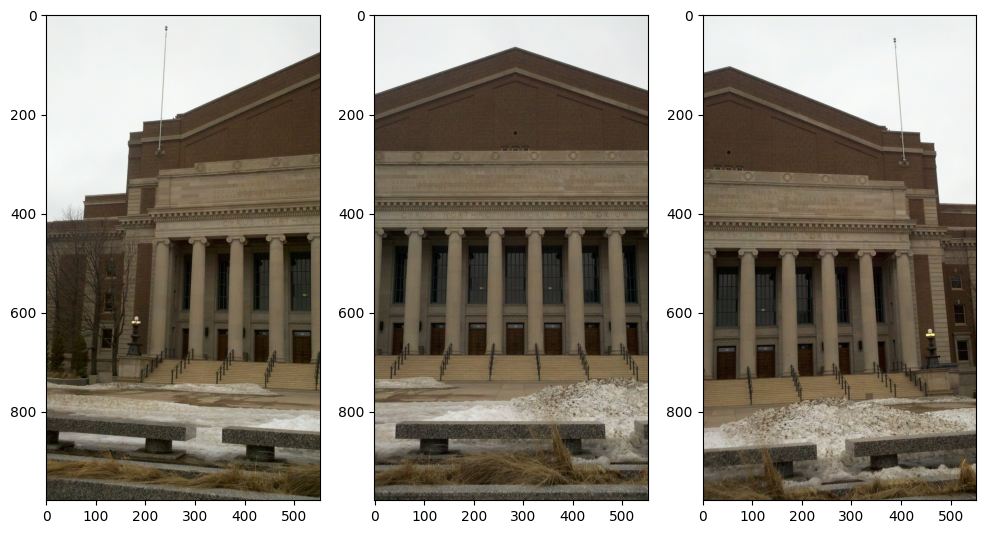

In [224]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 12 ,8

# read images
img1 = cv2.imread("Images/mall1.jpg")
img2 = cv2.imread("Images/mall2.jpg")
img3 = cv2.imread("Images/mall3.jpg")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# display images
fig, ax = plt.subplots(1,3)
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)

## Assignment Instructions:

In this assignment, you will perform image stitching and create a panorama of stitched images. Here are some basic steps you need to perform for image stiching:

    1. Detecting keypoints (DoG, Harris, etc.) and extracting local invariant descriptors (SIFT, SURF, ORB etc.) from two input images
    2. Matching the descriptors between the images
    3. Estimate a homography matrix using our matched feature vectors
    4. Applying a warping transformation using the homography matrix obtained from Step #3
    
<b> You may use opencv or other libraries for doing different tasks of this programming assignment.<\b>

In [225]:
stitcher = cv2.Stitcher.create(cv2.Stitcher_PANORAMA)

images=[img1, img2, img3]
status, panorama = stitcher.stitch(images)

if status == cv2.Stitcher_OK:
    plt.imshow(panorama)
    plt.show()
else:
    print("Error during stitching:", status)

In [206]:
# #keypoints
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

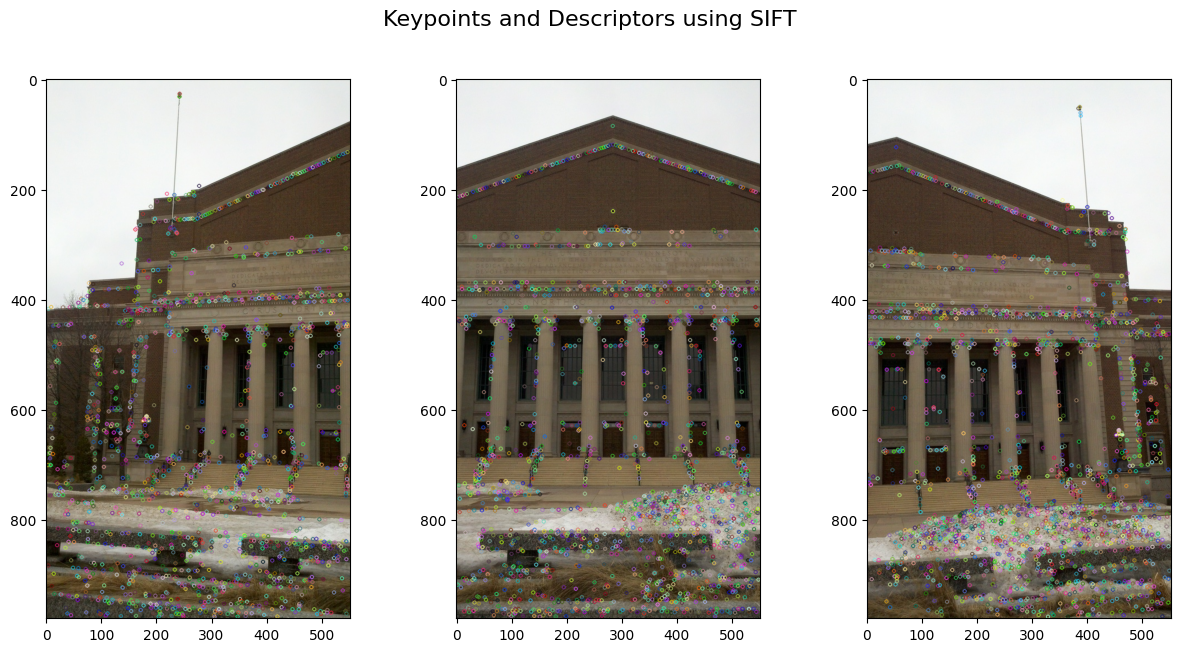

In [226]:
# Part1: keypoints and descriptors in one-line using detectAndCompute()

sift = cv2.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)
keypoints_3, descriptors_3 = sift.detectAndCompute(img3, None)

img_1 = cv2.drawKeypoints(img1,keypoints_1,img1)
img_2 = cv2.drawKeypoints(img2,keypoints_2,img2)
img_3 = cv2.drawKeypoints(img3,keypoints_3,img3)

# Showing keypoints and descriptors for each of the 3 images
plt.figure(figsize=(15,7))
plt.suptitle('Keypoints and Descriptors using SIFT', fontsize=16)
plt.subplot(1,3,1)
plt.imshow(img_1)
plt.subplot(1,3,2)
plt.imshow(img_2)
plt.subplot(1,3,3)
plt.imshow(img_3)
plt.show()

In [227]:
# Part2: Matching the extracted SIFT features using K-NN (k=4)

bf = cv2.BFMatcher()
matches12 = bf.knnMatch(descriptors_1, descriptors_2, k=2)
# matches23 = bf.knnMatch(descriptors_2, descriptors_3, k=2)

good_matches_12 = []
for m, n in matches12:
    if m.distance < 0.75 * n.distance:
        good_matches_12.append([m])

good_matches_23 = []
for m, n in matches23:
    if m.distance < 0.75 * n.distance:
        good_matches_23.append([m])

print(len(good_matches_12), len(good_matches_23))
match_image_12 = cv2.drawMatchesKnn(img_1, keypoints_1, img_2, keypoints_2, good_matches_12, outImg=None, matchColor=(0, 155, 0),
                             singlePointColor=(0, 255, 255), matchesMask=None, flags=0)

match_image_23 = cv2.drawMatchesKnn(img_2, keypoints_2, img_3, keypoints_3, good_matches_23, outImg=None, matchColor=(0, 155, 0),
                             singlePointColor=(0, 255, 255), matchesMask=None, flags=0)

plt.figure(figsize=(10,15))
plt.subplot(211)
plt.imshow(match_image_12)
plt.subplot(212)
plt.imshow(match_image_23)
plt.show()

375 590


In [262]:
# Extract location of good matches
points12_1 = np.float32([keypoints_1[m[0].queryIdx].pt for m in good_matches_12]).reshape(-1, 1, 2)
points12_2 = np.float32([keypoints_2[m[0].trainIdx].pt for m in good_matches_12]).reshape(-1, 1, 2)

# Find homography
h1, mask = cv2.findHomography(points12_1, points12_2, cv2.RANSAC, 5.0)

# Use homography
height, width = img2.shape[:2]
img2_warped = cv2.warpPerspective(img2, h, (width, height))

# Do the same above steps between image2 and image3
points23_1 = np.float32([keypoints_2[m[0].queryIdx].pt for m in good_matches_23]).reshape(-1, 1, 2)
points23_2 = np.float32([keypoints_3[m[0].trainIdx].pt for m in good_matches_23]).reshape(-1, 1, 2)

h2, mask = cv2.findHomography(points23_1, points23_2, cv2.RANSAC, 5.0)

height, width = img3.shape[:2]
img3_warped = cv2.warpPerspective(img3, h, (width, height))

plt.figure(figsize=(15, 15))
plt.subplot(211)
plt.imshow(img2_warped)
plt.subplot(212)
plt.imshow(img3_warped)
plt.show()

print('Estimated Homography:h1\n', h1)
print('Estimated Homography:h2\n', h2)

Estimated Homography:h1
 [[ 1.16409498e+00 -2.57114242e-02 -3.43467501e+02]
 [ 1.56798901e-01  1.12922867e+00 -8.61436103e+01]
 [ 2.79224710e-04  6.51410582e-06  1.00000000e+00]]
Estimated Homography:h2
 [[ 1.10642878e+00 -1.49232045e-02 -2.56434986e+02]
 [ 1.07263191e-01  1.05560248e+00  9.56033109e+00]
 [ 2.05412278e-04 -2.66984366e-05  1.00000000e+00]]


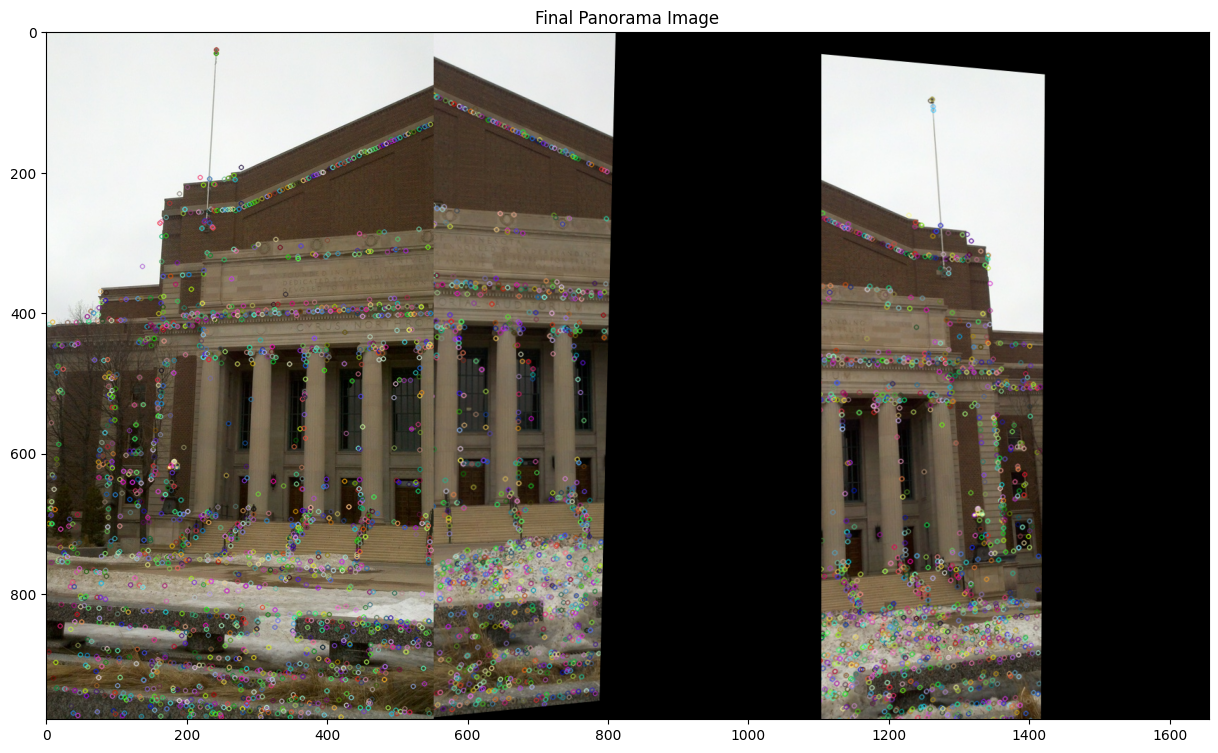

In [250]:
# Combine images to create the final panorama using homographies
final_panorama = cv2.warpPerspective(img1, np.eye(3), (width*3, height))
final_panorama[0:height, 0:width] = img1

# Use homography for warping img2
img2_warped = cv2.warpPerspective(img2, h1, (width*3, height))
final_panorama[0:height, width:2*width] = img2_warped[:, :width]

# Use homography for warping img3
img3_warped = cv2.warpPerspective(img3, h2, (width*3, height))
final_panorama[0:height, 2*width:] = img3_warped[:, :width]

# Display the final panorama
plt.figure(figsize=(15, 15))
plt.imshow(final_panorama)
plt.title('Final Panorama Image')
plt.show()



In [263]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Extract location of good matches
points12_1 = np.float32([keypoints_1[m[0].queryIdx].pt for m in good_matches_12]).reshape(-1, 1, 2)
points12_2 = np.float32([keypoints_2[m[0].trainIdx].pt for m in good_matches_12]).reshape(-1, 1, 2)

# Find homography
h1, mask = cv2.findHomography(points12_1, points12_2, cv2.RANSAC, 5.0)

# Use homography
height, width = img2.shape[:2]
img2_warped = cv2.warpPerspective(img2, h1, (width, height))

# Do the same above steps between image2 and image3
points23_1 = np.float32([keypoints_2[m[0].queryIdx].pt for m in good_matches_23]).reshape(-1, 1, 2)
points23_2 = np.float32([keypoints_3[m[0].trainIdx].pt for m in good_matches_23]).reshape(-1, 1, 2)

h2, mask = cv2.findHomography(points23_1, points23_2, cv2.RANSAC, 5.0)

height, width = img3.shape[:2]
img3_warped = cv2.warpPerspective(img3, h2, (width, height))

# Find useful width for img2_warped
useful_width_img2 = find_useful_width(img2_warped)

# Crop img2_warped to the useful width
img2_warped_cropped = img2_warped[:, :useful_width_img2]

# Find useful width for img3_warped
useful_width_img3 = find_useful_width(img3_warped)

# Crop img3_warped to the useful width
img3_warped_cropped = img3_warped[:, :useful_width_img3]

# Blend the images
final_panorama = np.zeros((height, width + useful_width_img2 + useful_width_img3, 3), dtype=np.uint8)

final_panorama[0:height, 0:width] = img2_warped_cropped
final_panorama[0:height, width:width + useful_width_img2] = img2_warped[:, :useful_width_img2]
final_panorama[0:height, width + useful_width_img2:] = img3_warped[:, :useful_width_img3]

# Display the final panorama
plt.figure(figsize=(15, 15))
plt.imshow(final_panorama)
plt.title('Final Panorama Image')
plt.show()


ValueError: could not broadcast input array from shape (979,260,3) into shape (979,552,3)

(979, 552, 3) (979, 260, 3) (979, 319, 3)


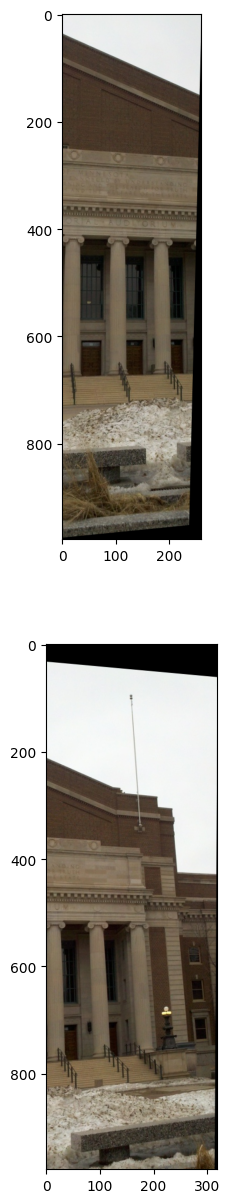

In [259]:
# Function to find the useful width of the warped image
def find_useful_width(img_warped):
    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img_warped, cv2.COLOR_RGB2GRAY)

    # Find contours in the grayscale image
    contours, _ = cv2.findContours(img_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate through contours to find the bounding box
    max_width = 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > max_width:
            max_width = w

    return max_width

# Use homography for warping img2
img2_warped = cv2.warpPerspective(img2, h1, (width*3, height))

# Find useful width for img2_warped
useful_width_img2 = find_useful_width(img2_warped)

# Crop img2_warped to the useful width
img2_warped_cropped = img2_warped[:, :useful_width_img2]

# Do the same above steps between image2 and image3
img3_warped = cv2.warpPerspective(img3, h2, (width*3, height))

# Find useful width for img3_warped
useful_width_img3 = find_useful_width(img3_warped)

# Crop img3_warped to the useful width
img3_warped_cropped = img3_warped[:, :useful_width_img3]

print(img1.shape, img2_warped_cropped.shape, img3_warped_cropped.shape)

plt.figure(figsize=(15, 15))
plt.subplot(211)
plt.imshow(img2_warped_cropped)
plt.subplot(212)
plt.imshow(img3_warped_cropped)
plt.show()


### Submission Guidelines:
        
        Submit through Canvas your source code in a single .ipynb file. 
        The name of the .ipynb file should be YourStudentID.ipynb. (For example: 1001234567.ipynb)
        The images are available in the ./Images directory. Your TA will use the same directory name to grade your submission.
        You don't need to attach the images folder with your submission.

## References

1. Keypoints and descriptors: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
2. SIFT behind the scenes understanding: https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/
3. Panoramic image stitching detailed paper: http://matthewalunbrown.com/papers/ijcv2007.pdf